The whats what of whos who about that thing they're trying to find over there:

- Moyal Distribution Instead of KDE? 
- Truncated average (Drop top 4, bottom 2) for Recoil tracker
- Average of Middle 68% of Event for Ecal 
- RMS Shower Width Attribute 
    - Log Energy weighted center of Shower
    - Log Energy weighted Shower Distance

- For Average, Truncated average ($\Delta_p/dx$), edep/ZShowerMax, Shower Width- (2 for recoil, 4 for ecal) - Generate ROC Curves
    - Create Boosted Decision Tree 

In [23]:
from coffea import hist
import math
from time import process_time
import os
import psutil
import uproot
import awkward as ak
from sklearn.neighbors import KernelDensity
from scipy.stats import moyal
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [24]:
with uproot.open("data/protonpion_Oct5/ntuple_gps_proton_100.00-2000.00MeV_50k_target_events_r0007_b2_104.root") as file:
    print(file["Events"].keys())
    print(file["Events"]["Ecal_SimHit_edep"].array())

['n_Sim_Particle', 'Sim_Particle_pdgID', 'Sim_Particle_trkID', 'Sim_Particle_mass', 'Sim_Particle_e', 'Sim_Particle_kine', 'Sim_Particle_vx', 'Sim_Particle_vy', 'Sim_Particle_vz', 'Sim_Particle_endx', 'Sim_Particle_endy', 'Sim_Particle_endz', 'Sim_Particle_px', 'Sim_Particle_py', 'Sim_Particle_pz', 'n_Recoil_SimHit', 'Recoil_SimHit_x', 'Recoil_SimHit_y', 'Recoil_SimHit_z', 'Recoil_SimHit_px', 'Recoil_SimHit_py', 'Recoil_SimHit_pz', 'Recoil_SimHit_pdgid', 'Recoil_SimHit_edep', 'Recoil_SimHit_pathLength', 'Recoil_SimHit_layer', 'n_Ecal_SimHit', 'Ecal_SimHit_edep', 'Ecal_SimHit_t', 'Ecal_SimHit_x', 'Ecal_SimHit_y', 'Ecal_SimHit_z', 'Ecal_SimHit_layer', 'n_Ecal_RecHit', 'Ecal_RecHit_amp', 'Ecal_RecHit_e', 'Ecal_RecHit_t', 'Ecal_RecHit_x', 'Ecal_RecHit_y', 'Ecal_RecHit_z', 'Ecal_RecHit_layer']
[[0.00793], [], [], [], [0.0236], [0.0226, ... [], [], [0.00883], [], [], []]


In [25]:
SimParticle_attrs = ['pdgID','trkID','mass','e','kine','vx','vy','vz','endx','endy','endz','px','py','pz']
RecoilSimHit_attrs = ['x', 'y', 'z', 'px', 'py', 'pz', 'pdgid', 'edep', 'pathLength', 'layer']
EcalSimHit_attrs = ['edep', 't', 'x', 'y', 'z', 'layer']
EcalRecHit_attrs = ['amp', 'e', 't', 'x', 'y', 'z', 'layer']


branches = {
    "Sim_Particle": SimParticle_attrs,
    "Recoil_SimHit": RecoilSimHit_attrs,
    "Ecal_SimHit": EcalSimHit_attrs,
    "Ecal_RecHit": EcalRecHit_attrs,
    "n": ["Sim_Particle", "Recoil_SimHit", "Ecal_SimHit", "Ecal_RecHit"]
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

#Repackages ldmx_dict into new dictionary of dictionaries of form
#ldmx_events={Sim_particle: {pdgID:___, trkID:___,...}, Ecal_RecHit: {amp:___, e:___, ...}, ...}
def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events


def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x


#Take the difference between consecutive measurements
def infinitesimalish(arr, lead=0):
    rtn=[]
    for evt in arr:
        evtArr=[]
        prev=evt[0]
        for hit in evt:
            evtArr.append(prev-hit)
            prev=hit
        
        evtArr[0]=lead
        rtn.append(evtArr)
    return ak.Array(rtn)

#Adds angle key:value entry to arr (Usually ldmx_events), using above method and LorentzVector class from coffea
def add_angle(arr):
    part=get_vector(arr)
    arr["theta"] = part.theta*(180/np.pi)
    return 

def add_angle_rTracker(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    },
                    with_name="ThreeVector")
    
    arr["theta"] = part.theta*(180/np.pi)
    
def add_momentum(arr):
    rho = np.sqrt(arr.px**2+arr.py**2+arr.pz**2)
    arr["momentum"] = rho
    return

#Returns ak.Record with coffea.LorentzVector behavior
def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part 
    
def cvBand(arr): 
    if len(arr)==1:
        return 1000
    elif len(arr)<5:
        cross=len(arr)
    else:
        cross=5
        
    bandwidths =np.linspace(0, 2, 100)
    grid = GridSearchCV(KernelDensity(kernel=kernel),
                    {'bandwidth': bandwidths},
                    cv=cross)
    bndwth=grid.fit(arr[:, None])
    best=bndwth.best_params_['bandwidth']
    return best

#best=cvBand(evt.edep)
#if best==1000:
    #match[spot]=evt.edep[0]
    #spot+=1
    #continue
        
def kernelDensity(arr):
    match=np.zeros(ak.num(arr, axis=0))
    spot=0
    for evt in arr:
        if len(evt)==1:
            match[spot]=evt[0]
            spot+=1
            continue
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(evt[:, np.newaxis])
        dens = np.exp(kde.score_samples(evt[:, np.newaxis]))
        mostLikely=max(dens)
        for i in range(len(dens)):
            if dens[i]==mostLikely: 
                match[spot]=evt[i]
                break
        spot+=1
    
    return match

In [26]:
histsAdd={}
#-----------------------------------------------------------------------------------------------------------------------
#----------------------------------- Additional Histograms -------------------------------------------------------------
#----------------------------------------------------------------------------------------------------------------------- 
ecalBins=[248, 253, 266, 274, 288, 297, 312, 321, 337, 346, 362, 371, 387, 396, 411, 421, 436, 445, 461, 470, 486, 495, 511, 520, 539, 552, 571, 583, 603, 615, 634, 647, 666, 679, 700]

#-----------Sim_Particle
histsAdd["simParticle_theta"]=hist.Hist("Sim_Particles", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sim_Particle Theta [Degrees]", 100, 0, 180),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))


#-----------Recoil_SimHit
histsAdd["recoil_sumEdepScatter"]={"Proton":np.array([[],[]]), "Pion":np.array([[],[]])}

histsAdd["recoil_avgEdep"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited by Recoil SimHits [MeV]", 100, 0, 1.5),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_mostProbable"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Most Probable dE/dx hit ($\Delta_{p}/dx$) in Recoil Tracker [MeV]", 100, 0, 1),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_sumEShowerMax"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sum $E_{dep}$ by Recoil Simhits/Z to Shower Max [MeV/mm]", 100, 0, 0.4),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

#-------------------------Whats Up With the Recoil Tracker and Sim Partcile Thetas?-----------
histsAdd["recoil_depth"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Furthest Layer", 10, 1, 11),
                            hist.Bin("s", "Kine", 100, 100, 2000)))

histsAdd["recoil_numHits"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Number of Hits in Recoil Tracker", 15, 0, 15),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_thetaLayer"]=hist.Hist("Sim Particles", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sim Particle Theta [Degrees]", 100, 0, 180),
                            hist.Bin("s", "Furthest Layer Hit", 10, 1, 11),
                            hist.Bin("p", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_thetaLayerAll"]=hist.Hist("Sim Particles", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Sim Particle Theta [Degrees]", 100, 0, 180),
                            hist.Bin("s", "Recoil Tracker Layers Hit", 10, 1, 11),
                            hist.Bin("p", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_thetaAtLayer"]=hist.Hist("Hits", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Theta at Given Layer", 100, 0, 180),
                            hist.Bin("s", "Layer", 10, 1, 11),
                            hist.Bin("p", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["recoil_endzFurthest"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sim Particle $End_z$", 100, 0, 750),
                            hist.Bin("s", "Furthest Layer Struck in Recoil Tracker", 10, 1, 11),
                            hist.Bin("p", "Kinetic Energy [MeV]",100, 100, 2000)))

#-----------Ecal_SimHit
histsAdd["ecalSim_avgEdep"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Energy Deposited by Ecal SimHits [MeV]", 100, 0, 1.0),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_showerWidth"]=hist.Hist("Events", axes=( 
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Shower Width [mm]", 100, 0, 1000),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_mostProbable"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"$\Delta_{p}/dx$ of Event (Ecal Simhit) [MeV]", 100, 0, 1),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_sumEShowerMax"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sum $E_{dep}$ by Ecal SimHits/r to Shower Max [MeV/mm]", 100, 0, 0.075),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalSim_hitShowerMax"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sum ($E_{dep}$/Z to Shower Max) for Ecal SimHits [MeV/mm]", 100, 0, 2.5),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

#----------Ecal_RecHit
histsAdd["ecalRec_avgDedz"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average dE/dz of Ecal RecHits [MeV]", 100, 0, 25),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_avgAmp"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Average Amplitudes of Ecal RecHits [MeV]", 100, 0, 0.8),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_showerWidth"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", "Shower Width [mm]", 100, 0, 1000),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_mostProbable"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"$\Delta_{p}/dx$ of Event (Ecal Rechit)", 100, 0, 13),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_sumEShowerMax"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sum $E_{dep}$ by Ecal RecHits/r to Shower Max [MeV/mm]", 100, 0, 0.2),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

histsAdd["ecalRec_hitShowerMax"]=hist.Hist("Events", axes=(
                            hist.Cat("particle", "Particle"),
                            hist.Bin("e", r"Sum ($E_{dep}$/Z to Shower Max) for Ecal SimHits [MeV/mm]", 100, -2, 50),
                            hist.Bin("s", "Kinetic Energy [MeV]",100, 100, 2000)))

In [27]:
def ProcessChunk(chunk):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_Particle']
    recoil_simhit = ldmx_events['Recoil_SimHit']
    ecal_simhit = ldmx_events['Ecal_SimHit']
    ecal_rechit = ldmx_events['Ecal_RecHit']


#------------------------------------------------------------------------------------------------------------    
#--------------------------------------- DATA MASKS/MANIPULATION --------------------------------------------
#------------------------------------------------------------------------------------------------------------    
    #Determines if data file is one for protons or pions
    par=""
    ID=0
    restMass=0
    if ak.all(sim_particle.pdgID==2212):
        par="Proton"
        ID=2212
        restMass=938.27208816
    elif ak.all(sim_particle.pdgID==211):
        par="Pion"
        ID=211
        restMass=139.57039
    
    #NEW ATTRIBUTES ADDED TO SIM_PARTICLES
    add_angle(sim_particle)
    '''
    #Select only Events where the theta is ~0
    zeroThetaMask=ak.flatten(sim_particle.theta<1, axis=None)
    #sim_particle=ak.mask(sim_particle, zeroThetaMask)
    recoil_simhit=ak.mask(recoil_simhit, zeroThetaMask)
    ecal_simhit=ak.mask(ecal_simhit, zeroThetaMask)
    ecal_rechit=ak.mask(ecal_rechit, zeroThetaMask)
    #'''
    
    #Removes empty events. There are a lot of empty events. 
    recoilEmptyMask=getattr(ldmx_events['n'], "Recoil_SimHit")!=0
    recoil_simhit=recoil_simhit[recoilEmptyMask]
    ecalEmptyMask=getattr(ldmx_events['n'], "Ecal_SimHit")!=0
    ecal_simhit=ak.flatten(ecal_simhit[ecalEmptyMask], axis=0)
    ecalRecEmptyMask=getattr(ldmx_events['n'], "Ecal_RecHit")!=0
    ecal_rechit=ak.flatten(ecal_rechit[ecalRecEmptyMask], axis=0)
    
    #pdgID Mask
    recoilIDMask=recoil_simhit.pdgid==ID
    
    #MIP Masks
    recoilMIPMask=recoil_simhit.edep>=.13
    ecalSimMIPMask=ecal_simhit.edep>=.13
    ecalRecMIPMask=ecal_rechit.e>=.13
    
    #dE/dz for variious data sets
    recoilSiWidth=0.32
    ecalSiWidth=0.5
    ecalRecWidths=[2.5,1.5,1.25,3,2.75,4.5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,5,4,8.5,7,8.5,7,8.5,7,8.5,7,8.5,7]
    recoilSpacing=[9.0, 6.0, 9.0, 6.0, 9.0, 6.0, 9.0, 6.0, 35.0, 90.0]
    
    #'''
    #NEW ATTRIBUTES ADDED TO RECOIL_SIMHITS
    recoil_simhit["dedz"]=recoil_simhit.edep/recoilSiWidth 
    add_angle_rTracker(recoil_simhit)
    
    #NEW ATTRIBUTES ADDED TO ECAL_SIMHITS
    ecal_simhit["dedz"]=ecal_simhit.edep/ecalSiWidth
    
    #NEW ATTRIBUTES ADDED TO ECAL_RECHITS
    widthMap=[[ecalRecWidths[hit] for hit in evt] for evt in ecal_rechit.layer]
    widthMap=ak.Array(widthMap)
    
    ecal_rechit["dedz"]=ecal_rechit.e/widthMap
    #'''
    
    #Range of iteration for kinetic energy 2d plots
    kineRange=np.linspace(100,1981,100)
    
    #------------------------------------Data Anlaysis/Histogram Filling------------------------------------------------
    
    #---------------Sim Particle
    
    
    #---------------Recoil Tracker
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask= recoilIDMask #& recoilMIPMask 
    emptiesIncluded=recoil_simhit[twoDMask]
    #Apply the emptyMask with ak.mask, so that the 1D data alignment is preserved. If you wished to preserve the 
    #2d alignment, you would apply the 2d mask with ak.mask as well. 
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    
    #def scatterFill(attr, collection, histCollection="histsAdd"):
    #    histsAdd["{}_{}"]
    
    
    #Fills Sum Energy Deposited Scatter Plot
    #sums=ak.flatten(ak.sum(prepared.edep, axis=1), axis=None)
    #kines=ak.flatten((sim_particle.kine[recoilEmptyMask])[emptiesMask], axis=None)
    #kines, _=ak.broadcast_arrays(kines, sums)
    
    #sums=ak.flatten(sums, axis=None)
    #kines=ak.flatten(kines, axis=None)
    #joint=([sums, kines])
    #histsAdd["recoil_sumEdepScatter"][par]=np.append(histsAdd["recoil_sumEdepScatter"][par], joint, axis=-1)
    
    
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        kineMask=kineMaskLower & kineMaskUpper
        #Changes kineMask to match recoil_simhit dimensions, since it was redefined to remove empty records. Changes kineMask to 1D
        oneDMask=ak.flatten(kineMask[recoilEmptyMask], axis=None)
        #Apply the OneDMask, and flatten at axis=0 to get rid of the top level "None" values which were empty arrays 
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        
        #Fills Energy Average
        edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
        edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
        histsAdd["recoil_avgEdep"].fill(particle=par, e=edepAvg, s=i)
        
        #Fills Number of Hits
        hits=ak.flatten(ak.num(noEmpties.edep, axis=1), axis=None)
        histsAdd["recoil_numHits"].fill(particle=par, e=hits, s=i)
        
        #Fills Depth
        depthMax=ak.flatten(ak.max(noEmpties.layer, axis=1), axis=None)
        histsAdd["recoil_depth"].fill(particle=par, e=depthMax, s=i)
        
        #Fills Most Probable Energy Loss 
        mostProb=ak.Array([moyal.fit(s)[0] for s in noEmpties.edep])
        
        histsAdd["recoil_mostProbable"].fill(particle=par, e=mostProb, s=i)
        
        #Fills Sum Energy Over Z to Shower Max
        showerMax=np.zeros(len(noEmpties))
        spot=0
        for evt in noEmpties:
            mx=max(evt.edep)
            for hit in evt:
                if hit.edep==mx:
                    R=np.sqrt((hit.z)**2+(hit.x)**2+(hit.y)**2)
                    showerMax[spot]=R
            spot+=1
            
        sumOverShower=edepSum/showerMax
            
        histsAdd["recoil_sumEShowerMax"].fill(particle=par, e=sumOverShower, s=i)
        #'''
    #------------------Investigating Theta in the Recoil Tracker and Sim Particles-------------------
    '''
        sameAlign=ak.flatten((ak.mask(sim_particle, ak.flatten(kineMask, axis=None))[recoilEmptyMask])[emptiesMask], axis=0)
        thetaMask=ak.flatten(sameAlign.theta<10, axis=None)
        sameAlign=sameAlign[thetaMask]
        noEmpties=noEmpties[thetaMask]
        depthMax=depthMax[thetaMask]
        
        #For Sim Particle Theta, recoil simTheta vs Furthest Layer and simTheta vs All Layers Hit
        theta=ak.flatten(sim_particle[kineMask].theta, axis=None)
        thetaL=ak.flatten(sameAlign.theta, axis=None)
        thetaLL, allLayers=ak.broadcast_arrays(thetaL, noEmpties.layer)
        allLayers=ak.flatten(allLayers, axis=None)
        thetaLL=ak.flatten(thetaLL, axis=None)
        
        #For recoilTheta vs layer and simEndz vs Furthest Layer Hit 
        endz=ak.flatten(sameAlign.endz, axis=None)
        thetas=ak.flatten(noEmpties.theta, axis=None)
        layers=ak.flatten(noEmpties.layer, axis=None)
        
        histsAdd["simParticle_theta"].fill(particle=par, e=theta, s=i)
        histsAdd["recoil_thetaLayer"].fill(particle=par, e=thetaL, s=depthMax, p=i)
        histsAdd["recoil_thetaLayerAll"].fill(particle=par, e=thetaLL, s=allLayers, p=i)
        histsAdd["recoil_thetaAtLayer"].fill(particle=par, e=thetas, s=layers, p=i)
        histsAdd["recoil_endzFurthest"].fill(particle=par, e=endz, s=depthMax, p=i)
        #'''
        
    print("Recoil Done")
    #'''
    #---------------Ecal_SimHits
    '''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalSimMIPMask
    emptiesIncluded=ecal_simhit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)
    
    #Fills Scatter Plot
    #didz=prepared.dedz
    #kines=ak.flatten(sim_particle.kine[ecalEmptyMask])
    #kines, dedzKine=ak.broadcast_arrays(kines, didz)
    
    #didz=ak.flatten(didz, axis=None)
    #kines=ak.flatten(kines, axis=None)
    #joint=([didz, kines])
    #histsAdd["ecalSim_dedzScatter"][par]=np.append(histsAdd["ecalSim_dedzScatter"][par], joint, axis=-1)
    
    
    #Looping for Kine Plots
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        kineMask=kineMaskLower & kineMaskUpper
        oneDMask=ak.flatten(kineMask[ecalEmptyMask], axis=None)
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        
        #Fills Energy Average
        edepSum=ak.flatten(ak.sum(noEmpties.edep, axis=1), axis=None)
        edepAvg=ak.flatten(ak.mean(noEmpties.edep, axis=1), axis=None)
        histsAdd["ecalSim_avgEdep"].fill(particle=par, e=edepAvg, s=i)
        
        #Fills Shower RMS Width
        #Find Center of Path
        weight=np.log(noEmpties.edep)
        centerX=ak.mean(weight*noEmpties.x, axis=1)
        centerY=ak.mean(weight*noEmpties.y, axis=1)
        
        R2=(weight*(noEmpties.x-centerX))**2+(weight*(noEmpties.y-centerY))**2
        rms=np.sqrt(ak.mean(R2, axis=1))
        
        histsAdd["ecalSim_showerWidth"].fill(particle=par, e=rms, s=i)

        #Fills Most Probable Energy Loss
        mostProb=ak.Array([moyal.fit(s)[0] for s in noEmpties.edep])
        
        histsAdd["ecalSim_mostProbable"].fill(particle=par, e=mostProb, s=i)
        
        #Fills Sum Energy over Z to Shower Max
        showerMax=np.zeros(len(noEmpties))
        showerXYZ=np.zeros((len(noEmpties), 3))
        spot=0
        for evt in noEmpties:
            mx=max(evt.edep)
            for hit in evt:
                if hit.edep==mx:
                    showerMax[spot]=(hit.z)
                    showerXYZ[spot]=[hit.x, hit.y, hit.z]
            spot+=1  
        sumOverShower=edepAvg/(showerMax-240)
            
        histsAdd["ecalSim_sumEShowerMax"].fill(particle=par, e=sumOverShower, s=i)
        
        #Fills ResidualMax and ResidualLast
        positionMax=list([0])*(ak.num(noEmpties.edep, axis=0))
        
        Last=ak.zip({"x":ak.flatten(ak.max(noEmpties.x, axis=1), axis=None), "y":ak.flatten(ak.max(noEmpties.y, axis=1), axis=None), "z":ak.flatten(ak.max(noEmpties.z, axis=1), axis=None)})
        positionLast=np.zeros(ak.count(noEmpties.edep, axis=None))
        
        ev=0
        for evt in noEmpties:
            spot=0
            shws=[0]*len(evt)
            
            shwmx=showerXYZ[ev]
            laymx=Last[ev]
            for hit in evt:
                distanceMax=np.sqrt((hit.x-shwmx[0])**2+(hit.y-shwmx[1])**2+(hit.z-shwmx[2])**2)
                if distanceMax==0:
                    distanceMax=1
                if hit.z<shwmx[2]: distanceMax=-distanceMax
                shws[spot]=distanceMax

                spot+=1
            positionMax[ev]=shws
            ev+=1
        
        positionMax=ak.Array(positionMax)
        sumShower=ak.sum(noEmpties.edep/positionMax, axis=1)
        
        histsAdd["ecalSim_hitShowerMax"].fill(particle=par, e=sumShower, s=i)
        
    print("Ecal SimHit Done")
    #'''
    #---------------Ecal_RecHits
    #'''
    #Preparing Masked Array to use in Kine Loop
    twoDMask=ecalRecMIPMask
    emptiesIncluded=ecal_rechit[twoDMask]
    emptiesMask=ak.num(emptiesIncluded)>0 
    prepared=ak.mask(emptiesIncluded, emptiesMask)

    
    #Fills Scatter Plot
    #didz=prepared.dedz
    #kines=ak.flatten(sim_particle.kine[ecalRecEmptyMask])
    #kines, dedzKine=ak.broadcast_arrays(kines, didz)
    
    #didz=ak.flatten(didz, axis=None)
    #kines=ak.flatten(kines, axis=None)
    #joint=([didz, kines])
    #histsAdd["ecalRec_dedzScatter"][par]=np.append(histsAdd["ecalRec_dedzScatter"][par], joint, axis=-1)
    
    
    #histsAdd["ecalRec_eOverP"], histsAdd["ecalRec_eMinusP"]
    for i in kineRange:
        kineMaskLower=sim_particle.kine>=i 
        kineMaskUpper=sim_particle.kine<(i+19)
        kineMask=kineMaskLower & kineMaskUpper
        oneDMask=ak.flatten(kineMask[ecalRecEmptyMask], axis=None)
        noEmpties=ak.flatten(prepared[oneDMask], axis=0)
        
        
        #Fills  Average dedz 
        sumdedz=ak.flatten(ak.mean(noEmpties.dedz, axis=1), axis=None)
        avgdedz=ak.flatten(ak.mean(noEmpties.dedz, axis=1), axis=None)
        histsAdd["ecalRec_avgDedz"].fill(particle=par, e=avgdedz, s=i)
        
        #Fills  Average Amplitude
        avgAmp=ak.flatten(ak.mean(noEmpties.amp, axis=1), axis=None)
        histsAdd["ecalRec_avgAmp"].fill(particle=par, e=avgAmp, s=i)
      
        #Fills Shower RMS Width
        weight=np.log(noEmpties.dedz)
        centerX=ak.mean(weight*noEmpties.x, axis=1)
        centerY=ak.mean(weight*noEmpties.y, axis=1)
        
        R2=(weight*(noEmpties.x-centerX))**2+(weight*(noEmpties.y-centerY))**2
        rms=np.sqrt(ak.mean(R2, axis=1))
        
        histsAdd["ecalRec_showerWidth"].fill(particle=par, e=rms, s=i)

        #Fills Most Probable Energy Loss
        mostProb=ak.Array([moyal.fit(s)[0] for s in noEmpties.dedz])
        
        histsAdd["ecalRec_mostProbable"].fill(particle=par, e=mostProb, s=i)
        
        #Fills Sum Energy over Z to Shower Max
        showerMax=np.zeros(len(noEmpties))
        
        spot=0
        for evt in noEmpties:
            mx=max(evt.dedz)
            for hit in evt:
                if hit.dedz==mx:
                    R=np.sqrt((hit.z-240)**2+(hit.x)**2+(hit.y)**2)
                    showerMax[spot]=R
            spot+=1   
        sumOverShower=sumdedz/(showerMax)#-240)
            
        histsAdd["ecalRec_sumEShowerMax"].fill(particle=par, e=sumOverShower, s=i)
        
        
    print("Ecal RecHit Done")
    #'''
    #------------------------------------------------------------------------------------------


In [28]:
ldmx_dict_all = getData(chunks=True, fnames="data/protonpion_Oct5/*.root")

start=process_time()
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk)
    
stop=process_time()
print("Elapsed time during the whole program in seconds:", stop-start) 

process 1


C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1833: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))
C:\Users\Acer\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6005: RuntimeWarning: overflow encountered in exp
  return np.exp(-0.5 * (x + np.exp(-x))) / np.sqrt(2*np.pi)


Recoil Done
Ecal RecHit Done
process 2
Recoil Done
Ecal RecHit Done
process 3
Recoil Done
Ecal RecHit Done
process 4
Recoil Done
Ecal RecHit Done
process 5
Recoil Done
Ecal RecHit Done
process 6
Recoil Done
Ecal RecHit Done
Elapsed time during the whole program in seconds: 2108.296875


C:\Users\Acer\anaconda3\lib\site-packages\coffea\hist\plot.py:573: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  pc = ax.pcolormesh(xedges, yedges, sumw.T, **opts)


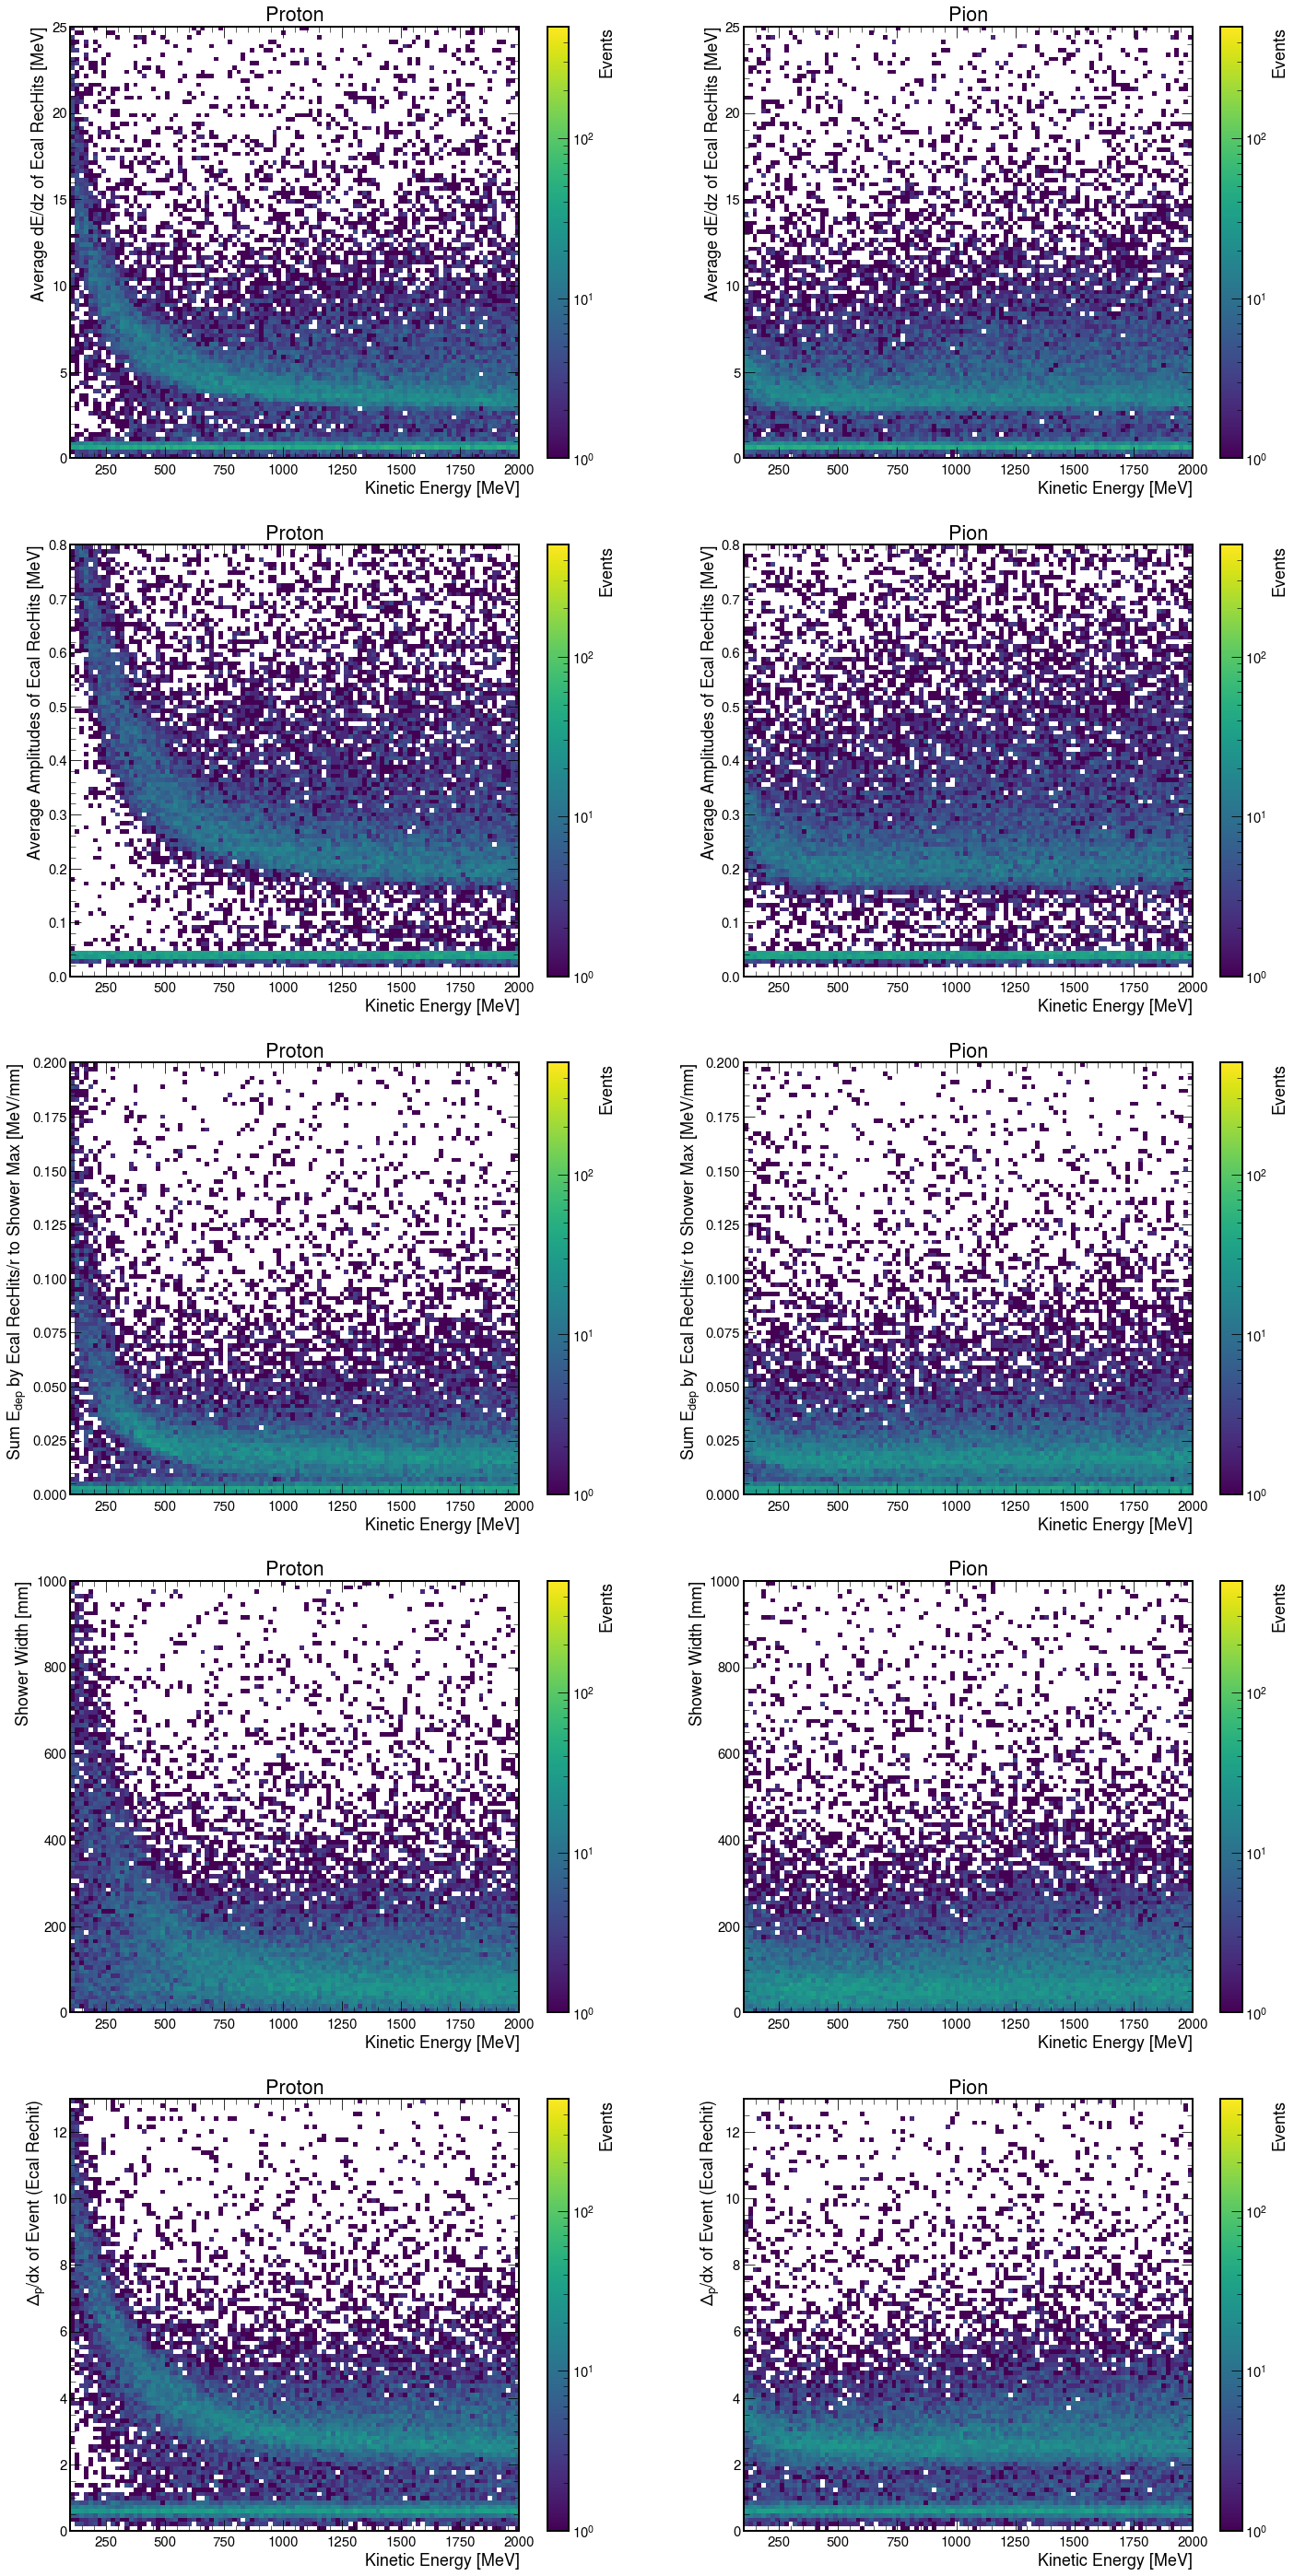

In [29]:
import ipywidgets as widgets
%matplotlib inline
from matplotlib import rcParams
from matplotlib import colors
from matplotlib import cm
plt.rcParams.update({'font.size': 18})


#------------------------------------- Plots ---------------------------------------------------
def threeDPlot(names, kineLow=100, kineUpper=499):
    numP=len(names)
    fig, ax=plt.subplots(ncols=2, nrows=numP, figsize=(24, 10*numP))
    
    for i in range(0, numP):
        hist.plot2d(histsAdd[names[i]]["Proton"].sum("particle")[:,:,kineLow:kineUpper].sum("p"), "s", ax=ax[i, 0], clear=True,  patch_opts={'norm': colors.LogNorm(), 'vmax': 5*10**2})
        hist.plot2d(histsAdd[names[i]]["Pion"].sum("particle")[:,:,kineLow:kineUpper].sum("p"), "s", ax=ax[i, 1], clear=True,  patch_opts={'norm': colors.LogNorm(), 'vmax': 5*10**2})
        ax[i, 0].set_title("Proton")
        ax[i, 1].set_title("Pion")

def twoDPlot(names):
    numP=len(names)
    fig, ax=plt.subplots(ncols=2, nrows=numP, figsize=(24, 10*numP))
    for i in range(0, numP):
        hist.plot2d(histsAdd[names[i]]["Proton"].sum("particle"), "s", ax=ax[i, 0], clear=True, patch_opts={'norm': colors.LogNorm(), 'vmax': 5*10**2})
        hist.plot2d(histsAdd[names[i]]["Pion"].sum("particle"), "s", ax=ax[i, 1], clear=True, patch_opts={'norm': colors.LogNorm(),  'vmax': 5*10**2})
        ax[i, 0].set_title("Proton")
        ax[i, 1].set_title("Pion")
        
def twoDPlotHori(names):
    numP=len(names)
    fig, ax=plt.subplots(ncols=2, nrows=numP+1, figsize=(24, 10*numP+1))
    for i in range(0, numP):
        hist.plot2d(histsAdd[names[i]]["Proton"].sum("particle"), "s", ax=ax[i-(i%2), i%2], clear=True, patch_opts={'norm': colors.LogNorm(), 'vmax': 5*10**2})
        hist.plot2d(histsAdd[names[i]]["Pion"].sum("particle"), "s", ax=ax[i+1-(i%2), i%2], clear=True, patch_opts={'norm': colors.LogNorm(),  'vmax': 5*10**2})
        ax[i-(i%2), i%2].set_title("Proton")
        ax[i+1-(i%2), i%2].set_title("Pion")
        #hist.plot2d(histsAdd[names[i]]["Proton"].sum("particle"), "s", ax=ax[i, i%2+1], clear=True, patch_opts={'norm': colors.LogNorm(), 'vmax': 5*10**2})
        #hist.plot2d(histsAdd[names[i]]["Pion"].sum("particle"), "s", ax=ax[i+1, i%2+1], clear=True, patch_opts={'norm': colors.LogNorm(),  'vmax': 5*10**2})
        #ax[i, 1].set_title("Proton")
        #ax[i+1, 1].set_title("Pion")
        
        
def scatterHist(data, histo, cutoff):
    newPro=[[],[]]
    newPio=[[],[]] 
    proZs=[]
    pioZs=[]
    
    for i in range(len(data["Proton"][0])):
        #Finds histogram bin for kine
        kineIndx=math.floor((data["Proton"][1][i]-100)/19)
        #Uses histogram to find bin for dedz
        dedzIndx=histo.axes()[1].index(data["Proton"][0][i])-1
        #If point is in histogram overflow bin, leave it
        if dedzIndx==100: continue
        freq=histo.values()[('Proton',)][dedzIndx][kineIndx]
        #If greater than five occurences add to new list, else drop. Additionally add the hist count to the Z-value array
    
        if freq>=cutoff:
            newPro[0].append(data["Proton"][0][i])
            newPro[1].append(data["Proton"][1][i])
            proZs.append(histo.values()[('Proton',)][dedzIndx][kineIndx])

    for i in range(len(data["Pion"][0])):
        kineIndx=math.floor((data["Pion"][1][i]-100)/19)
        dedzIndx=histo.axes()[1].index(data["Pion"][0][i])-1
        if dedzIndx==100: continue
        freq=histo.values()[('Pion',)][dedzIndx][kineIndx]
    
        if freq>=cutoff:
            newPio[0].append(data["Pion"][0][i])
            newPio[1].append(data["Pion"][1][i])
            pioZs.append((histo.values()[('Pion',)][dedzIndx][kineIndx])*-1)

    return newPro, newPio, proZs, pioZs


#--------------------------------------------------------------------------------------------------
#                               All graphs have a MIP mask on them
#--------------------------------------------------------------------------------------------------
#'''
names=np.array(["recoil_avgEdep", "recoil_mostProbable", "recoil_sumEShowerMax", "recoil_numHits",
                "ecalRec_avgDedz", "ecalRec_avgAmp", "ecalRec_sumEShowerMax", "ecalRec_showerWidth", 
                "ecalRec_mostProbable"])


#names3D=np.array(["recoil_thetaLayer", "recoil_thetaLayerAll", "recoil_thetaAtLayer", "recoil_endzFurthest"])
#twoDPlot(["recoil_numHits", "recoil_depth", "ecalRec_avgDedz", "ecalRec_sumEShowerMax"])

#twoDPlotHori(names)
twoDPlot(["ecalRec_avgDedz", "ecalRec_avgAmp", "ecalRec_sumEShowerMax", "ecalRec_showerWidth", "ecalRec_mostProbable"])


#Ranges- :499, 499:765, 765:1050, 1050:1525, 1525:2000
#threeDPlot(names3D, 100, 2000)
#threeDPlot(names3D, 499, 1050)
#threeDPlot(names3D, 1525, 2000)


#--------------------------Special Graphs------------------------------------------------------------

#------------------ Recoil
'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["recoil_dedzScatter"], histsAdd["recoil_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))v
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-100, vmax=100, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-100, vmax=100, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Recoil Tracker dE/dz vs. Kinetic Energy")
ax.set_ylim([0,2])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")

#'''
#------------------ Ecal SimHit
'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["ecalSim_dedzScatter"], histsAdd["ecalSim_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
#plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Ecal SimHit dE/dz vs. Kinetic Energy")
ax.set_ylim([0,2])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")
#'''
#----------------- Ecal RecHit
'''
newPro, newPio, proZs, pioZs=scatterHist(histsAdd["ecalRec_dedzScatter"], histsAdd["ecalRec_dedzMIP"], 30)

fig, ax=plt.subplots(figsize=(12,10))
plt.scatter(newPro[1], newPro[0], c=proZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Proton")
#plt.scatter(newPio[1], newPio[0], c=pioZs, vmin=-200, vmax=200, cmap=plt.cm.RdBu, marker=".", alpha=1, label="Pion")
cbar=plt.colorbar(label= "Event count")

plt.legend(scatterpoints=6)
ax.set_title("Ecal RecHit dE/dz vs. Kinetic Energy")
ax.set_ylim([0,20])
ax.set_xlim([100,2000])
ax.set_xlabel("Kinetic Energy [MeV]")
ax.set_ylabel("dE/dz [MeV/mm]")
#'''

plt.show()
#"""

'\nfig5, ax5=plt.subplots(figsize=(10, 10))\nthreeROC(histsAdd["ecalRec_sumEShowerMax"], 5, fig5)\nplt.plot([0,1],[0,1],"--", figure=fig5, label="Random Classifier")\nfig5.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)\ntitle="Ecal RecHit, Sum of dE/dz over Z to Shower Max, TPR for Protons"\nfig5.suptitle(title, ha=\'center\', y=0.05, fontsize=14)\nax5.set_ylabel("TPR")\nax5.set_xlabel("FPR")\n#'

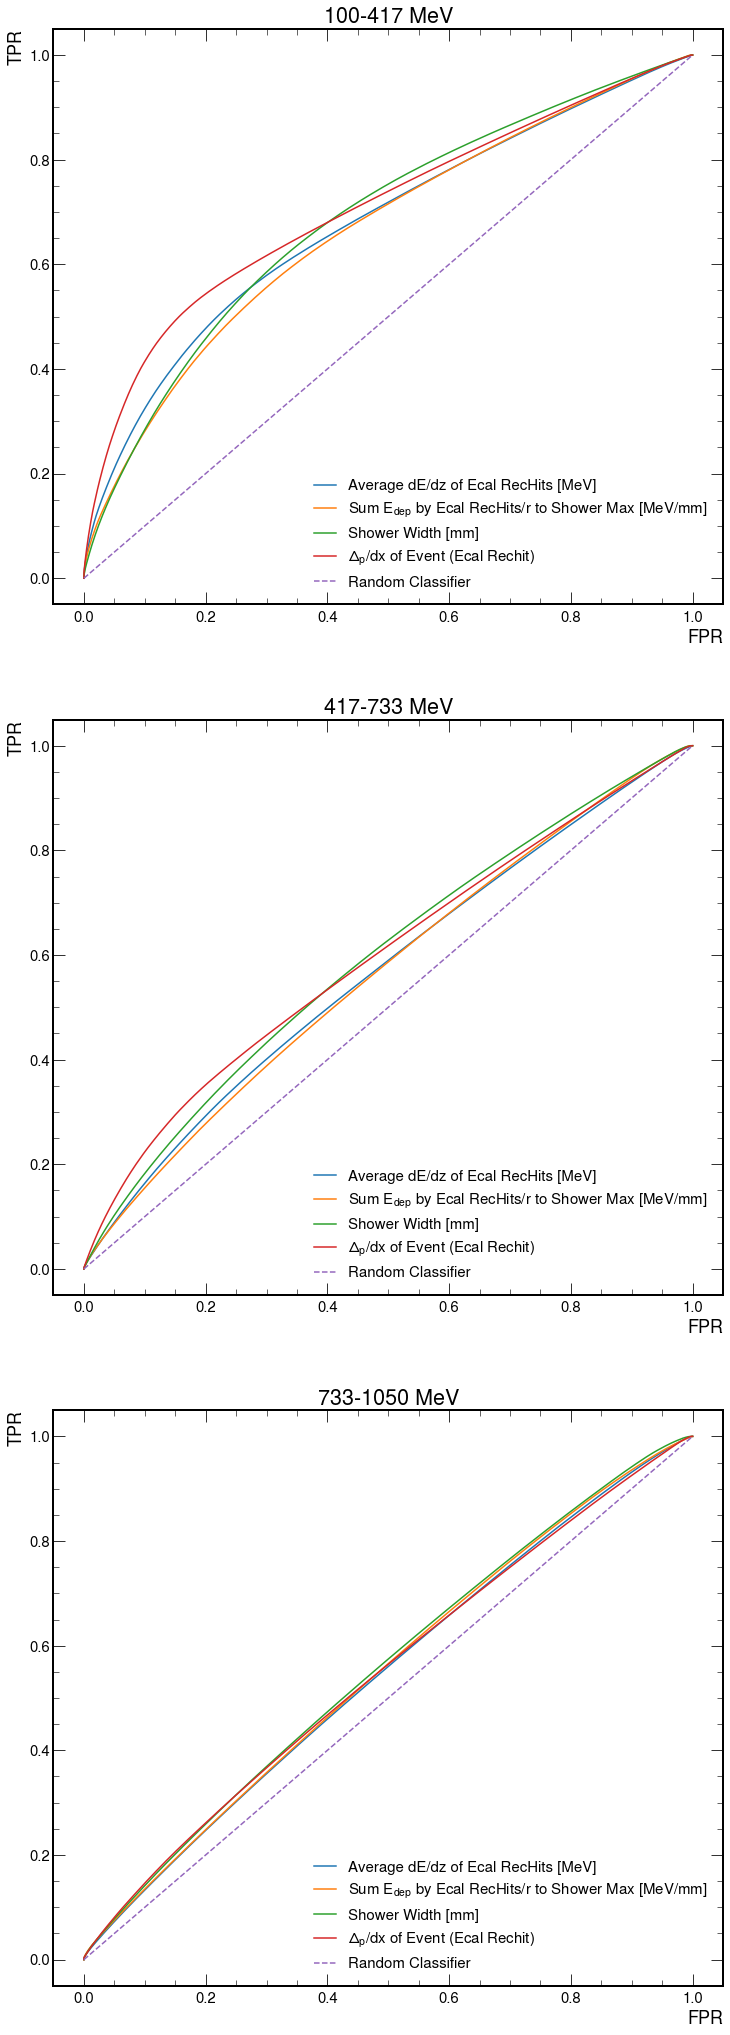

In [30]:
#"""
#------------------------------------------------------------------------------------------------------
#----------------------------------ROC Curves----------------------------------------------------------
#------------------------------------------------------------------------------------------------------
from sklearn import metrics

#Choose a threshold  from range(lower to upper), generate the dataset for that range (cut the propio merge at that threshold)
#calculate the probability for a proton from the actual data set(sum(targetWeights_pro)/sum(merge(targetWeights_pro and _pio)))
#broadcast probability to dataset. Run metrics.roc_curve with y_true as the "dataset" and the broadcast probability as the
#y_score, and sample_weights=targetWeights

#Creates y_true binary array
def parLabel(arr, pdgID):
    return [pdgID for x in arr]

#tacks on arr2 to arr1 at the innermost dimension
def merge(arr1, arr2):
    return np.append(arr1, arr2, axis=-1)
    

#Generates ROC curves True, Score, and Sample_Weight parameters given 2d histogram arrays for proton and pion. 
#Upper and Lower refer to y axis of the plot.
def ROCKdat(proton, pion):
    arrsize=len(proton)
    bigtrue=np.zeros(int((arrsize)*(arrsize+1)))
    bigscore=np.zeros(int((arrsize)*(arrsize+1)))
    bigweights=np.zeros(int((arrsize)*(arrsize+1)))
    
    proWeights=proton
    pioWeights=pion
    proLabels=parLabel(proton, 2212)
    pioLabels=parLabel(pion, 211)
    
    #Used for determining array indices
    counter=arrsize
    for i in np.arange(0, arrsize):
        y_true=merge(proLabels[i:],pioLabels[i:])
        #Check This
        if (all(proWeights[i:]==0)):
            proton_prob=0.000001
        else:
            proton_prob=np.sum(proWeights[i:])/(np.sum(proWeights[i:])+np.sum(pioWeights[i:]))
        #Produces same Graphs as Scoring Code above
        #proton_prob=(1/arrsize)*i
        y_score=[proton_prob]*(arrsize-i)*2
        weights=merge(proWeights[i:], pioWeights[i:])
        
        n=arrsize-counter
        up=((n+1)*arrsize-(n*(n+1))//2)*2
        lo=up-counter*2
        bigtrue[lo:up]=y_true
        bigscore[lo:up]=y_score
        bigweights[lo:up]=weights
        counter-=1
        
    #print(bigtrue)
    return bigtrue, bigscore, bigweights
                                    
    
#For 2d histogram arrays, the rows are the de/dz, the columns are kine. 
def threeROC(histogram, numROC):#, fig):
    proton=histogram.values()[('Proton',)]
    pion=histogram.values()[('Pion',)]
    kinesize=len(proton)
    step=kinesize/numROC
    ret=np.zeros((numROC, 3, 10000))
    
    spot=0
    for i in np.linspace(step, kinesize, numROC):
        gauss=(kinesize+1)*(kinesize)
        lo=math.floor(i-step)
        up=math.floor(i)
        ytru=np.zeros(gauss*(up-lo))
        ysco=np.zeros(gauss*(up-lo))
        weig=np.zeros(gauss*(up-lo))
        
        for j in range(lo,up):
            lndx=gauss*(j-lo)
            hndx=lndx+gauss
            ytru[lndx:hndx], ysco[lndx:hndx], weig[lndx:hndx]=ROCKdat(np.ndarray.flatten(proton[:, j]), np.ndarray.flatten(pion[:, j]))
            
        fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)
        ret[spot]= ak.to_numpy(ak.pad_none([fpr, tpr, [len(fpr)]], 10000, axis=1))
        spot+=1
        #print(thresholds)
        #plt.plot(fpr, tpr, figure=fig, label="{}-{}GeV".format(0.1+round((i-step)*0.019, 3), round(0.1+i*0.019, 3)))
    return ret
    


#fig1, ax1=plt.subplots(figsize=(10, 10))
#threeROC(histsAdd["ecalRec_mostProbable"], 5, fig1)

recoilROCs=["recoil_avgEdep", "recoil_numHits"]#, "recoil_mostProbable", "recoil_sumEShowerMax"]
ecalROCs=["ecalRec_avgDedz", "ecalRec_sumEShowerMax", "ecalRec_showerWidth", "ecalRec_mostProbable"]# "ecalRec_avgAmp",

def compareROCs(names, divi):
    num=len(names)
    fig, ax=plt.subplots(nrows=3, figsize=(12, 36))
    
    prs=np.zeros((num, 3, 3, 10000))
    for i in range(num):
        prs[i]=threeROC(histsAdd[names[i]], divi)[:3]

    for i in range(3):
        for j in range(num):
            dataLen=int(prs[j, i, 2, 0])
            ax[i].plot(prs[j, i, 0][:dataLen], prs[j, i, 1][:dataLen], label=histsAdd[names[j]].axis("e").label)
            
        ax[i].plot([0,1],[0,1], "--", figure=fig, label="Random Classifier")
        ax[i].legend(loc="lower right")
        ax[i].set_ylabel("TPR")
        ax[i].set_xlabel("FPR")
        ax[i].set_title("{}-{} MeV".format(int(100+round((1900/divi)*i, 0)), int(100+round((1900/divi)*(i+1), 0))))
        
compareROCs(recoilROCs, 6)  
compareROCs(ecalROCs, 6)  
#compareROCs(["recoil_sumEShowerMax", "ecalRec_sumEShowerMax"], 6)  

'''  
fig1, ax1=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["recoil_momentum"], 5, fig1) 
plt.plot([0,1],[0,1],"--", figure=fig1, label="Random Classifier")
fig1.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Recoil tracker, Last Hit Momentum, TPR for Protons"
fig1.suptitle(title, ha='center', y=0.05, fontsize=14)
ax1.set_ylabel("TPR")
ax1.set_xlabel("FPR")
#'''

'''
fig4, ax4=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["recoil_mostProbable"], 5, fig4)
plt.plot([0,1],[0,1],"--", figure=fig4, label="Random Classifier")
fig4.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Recoil Tracker, $\Delta_p/dx$, TPR for Protons"
fig4.suptitle(title, ha='center', y=0.05, fontsize=14)
ax4.set_ylabel("TPR")
ax4.set_xlabel("FPR")
#'''

'''
fig2, ax2=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalSim_mostProbable"], 5, fig2)
plt.plot([0,1],[0,1],"--", figure=fig2, label="Random Classifier")
fig2.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title=r"Ecal SimHit, $\Delta_p/dx$, TPR for Protons"
fig2.suptitle(title, ha='center', y=0.05, fontsize=14)
ax2.set_ylabel("TPR")
ax2.set_xlabel("FPR")
#'''

'''
fig3, ax3=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalRec_mostProbable"], 5, fig3)
plt.plot([0,1],[0,1],"--", figure=fig3, label="Random Classifier")
fig3.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal RecHit, $\Delta_p/dx$, TPR for Protons"
fig3.suptitle(title, ha='center', y=0.05, fontsize=14)
ax3.set_ylabel("TPR")
ax3.set_xlabel("FPR")
#'''



'''
fig5, ax5=plt.subplots(figsize=(10, 10))
threeROC(histsAdd["ecalRec_sumEShowerMax"], 5, fig5)
plt.plot([0,1],[0,1],"--", figure=fig5, label="Random Classifier")
fig5.legend(loc=(0.6,0.15), fontsize=14, title="Kine Range of Data", title_fontsize=14)
title="Ecal RecHit, Sum of dE/dz over Z to Shower Max, TPR for Protons"
fig5.suptitle(title, ha='center', y=0.05, fontsize=14)
ax5.set_ylabel("TPR")
ax5.set_xlabel("FPR")
#'''
    
#ytru, ysco, weig= ROCKdat(protondedz, piondedz, 0, 0.30)
#fpr, tpr, thresholds=metrics.roc_curve(ytru, ysco, pos_label=2212, sample_weight=weig)

#fig2, ax2=plt.subplots()
#plt.plot(fpr, tpr, figure=fig2)
#"""